In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import dgl
from dgl import DGLGraph

# Load Pytorch as backend
dgl.load_backend('pytorch')

Using backend: pytorch
Using backend: pytorch


In [3]:
import numpy as np

In [4]:
from dgl.nn.pytorch import conv as dgl_conv

class GraphSAGEModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGEModel, self).__init__()
        self.layers = nn.ModuleList()

        # input layer
        self.layers.append(dgl_conv.SAGEConv(in_feats, n_hidden, aggregator_type,
                                         feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(dgl_conv.SAGEConv(n_hidden, n_hidden, aggregator_type,
                                             feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(dgl_conv.SAGEConv(n_hidden, out_dim, aggregator_type,
                                         feat_drop=dropout, activation=None))

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        return h

In [5]:
from dgl.data import citegrh

# load and preprocess the pubmed dataset
data = citegrh.load_pubmed()

# sparse bag-of-words features of papers
features = torch.FloatTensor(data.features)
# the number of input node features
in_feats = features.shape[1]
# class labels of papers
labels = torch.LongTensor(data.labels)
# the number of unique classes on the nodes.
n_classes = data.num_labels

Finished data loading and preprocessing.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000


In [6]:
data.graph.remove_edges_from(data.graph.selfloop_edges())

In [7]:
g = DGLGraph(data.graph)
g.readonly()

In [8]:
g

DGLGraph(num_nodes=19717, num_edges=88648,
         ndata_schemes={}
         edata_schemes={})

In [9]:
# Hyperparameters
n_hidden = 64
n_layers = 2
dropout = 0.5
aggregator_type = 'gcn'

gconv_model = GraphSAGEModel(in_feats,
                             n_hidden,
                             n_classes,
                             n_layers,
                             F.relu,
                             dropout,
                             aggregator_type)

In [10]:
class NodeClassification(nn.Module):
    def __init__(self, gconv_model, n_hidden, n_classes):
        super(NodeClassification, self).__init__()
        self.gconv_model = gconv_model
        #self.loss_fcn = torch.nn.CrossEntropyLoss()

    def forward(self, g, features, train_mask):
        logits = self.gconv_model(g, features)
        return logits
        #return self.loss_fcn(logits[train_mask], labels[train_mask])

In [11]:
def NCEvaluate(model, g, features, labels, test_mask):
    model.eval()
    with torch.no_grad():
        # compute embeddings with GNN
        logits = model.gconv_model(g, features)
        logits = logits[test_mask]
        test_labels = labels[test_mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == test_labels)
        return correct.item() * 1.0 / len(test_labels)

In [12]:
# the dataset is split into training set, validation set and testing set.
train_mask = torch.BoolTensor(data.train_mask)
val_mask = torch.BoolTensor(data.val_mask)
test_mask = torch.BoolTensor(data.test_mask)

print("""----Data statistics------'
      #Classes %d
      #Train samples %d
      #Val samples %d
      #Test samples %d""" %
          (n_classes,
           data.train_mask.sum().item(),
           data.val_mask.sum().item(),
           data.test_mask.sum().item()))

----Data statistics------'
      #Classes 3
      #Train samples 60
      #Val samples 500
      #Test samples 1000


In [25]:
model = NodeClassification(gconv_model, n_hidden, n_classes)
loss_fcn = torch.nn.CrossEntropyLoss()

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 10
lr = 1e-3

# create the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    # Set the model in the training mode.
    model.train()
    # forward
    logits = model(g, features, train_mask)
    loss = loss_fcn(logits[train_mask], labels[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = NCEvaluate(model, g, features, labels, val_mask)
    print("Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f}"
          .format(epoch, loss.item(), acc))

print()
acc = NCEvaluate(model, g, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

Epoch 00000 | Loss 0.9183 | Accuracy 0.7400
Epoch 00001 | Loss 0.9091 | Accuracy 0.7360
Epoch 00002 | Loss 0.9149 | Accuracy 0.7400
Epoch 00003 | Loss 0.8898 | Accuracy 0.7400
Epoch 00004 | Loss 0.8851 | Accuracy 0.7420
Epoch 00005 | Loss 0.9060 | Accuracy 0.7440
Epoch 00006 | Loss 0.8889 | Accuracy 0.7400
Epoch 00007 | Loss 0.8823 | Accuracy 0.7340
Epoch 00008 | Loss 0.8498 | Accuracy 0.7400
Epoch 00009 | Loss 0.8446 | Accuracy 0.7360

Test Accuracy 0.7180


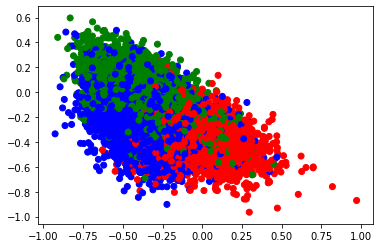

In [26]:
from cell import plot_utils

emb = pd.DataFrame(logits.detach().numpy(), columns=["Z0", "Z1", "Z2"])
emb['class'] = data.labels
def color_df(df):

    if (df['class'] == 0):
        return 'Red'
    elif (df['class'] == 1):
        return 'green'
    elif (df['class'] == 2):
        return 'blue'

emb['cluster_color'] = emb.apply(color_df, axis = 1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(emb["Z0"], emb["Z1"], c = emb['cluster_color'])

plt.show()

# Link prediction 

In [8]:
#Model hyperparameters
n_hidden = 200
n_layers = 1
dropout = 0.5
aggregator_type = 'gcn'

# create GraphSAGE model
gconv_model = GraphSAGEModel(in_feats,
                             n_hidden,
                             n_hidden,
                             n_layers,
                             F.relu,
                             dropout,
                             aggregator_type)

In [9]:
# NCE loss
def NCE_loss(pos_score, neg_score, neg_sample_size):
    pos_score = F.logsigmoid(pos_score)
    neg_score = F.logsigmoid(-neg_score).reshape(-1, neg_sample_size)
    return -pos_score - torch.sum(neg_score, dim=1)

class LinkPrediction(nn.Module):
    def __init__(self, gconv_model):
        super(LinkPrediction, self).__init__()
        self.gconv_model = gconv_model

    def forward(self, g, features, neg_sample_size):
        emb = self.gconv_model(g, features)
        pos_g, neg_g = edge_sampler(g, neg_sample_size, return_false_neg=False)
        pos_score = score_func(pos_g, emb)
        neg_score = score_func(neg_g, emb)
        return emb, torch.mean(NCE_loss(pos_score, neg_score, neg_sample_size))

In [10]:
def edge_sampler(g, neg_sample_size, edges=None, return_false_neg=True):
    sampler = dgl.contrib.sampling.EdgeSampler(g, batch_size=int(g.number_of_edges()/10),
                                               seed_edges=edges,
                                               neg_sample_size=neg_sample_size,
                                               negative_mode='tail',
                                               shuffle=True,
                                               return_false_neg=return_false_neg)
    sampler = iter(sampler)
    return next(sampler)

In [22]:
p, n = edge_sampler(g, 1, return_false_neg=False)
emb = gconv_model(g, features)

In [23]:
print(score_func(p, emb))
print(score_func(n, emb))

tensor([0.0054, 0.0087, 0.0105,  ..., 0.0042, 0.0048, 0.0048],
       grad_fn=<SumBackward1>)
tensor([0.0032, 0.0046, 0.0028,  ..., 0.0037, 0.0033, 0.0027],
       grad_fn=<SumBackward1>)


In [24]:
g.has_edges_between(p.edges()[0].numpy(), p.edges()[1].numpy())

tensor(2)

In [25]:
sum(g.has_edges_between(n.edges()[0].numpy(), n.edges()[1].numpy()))

tensor(5)

In [13]:
def score_func(g, emb):
    src_nid, dst_nid = g.all_edges(order='eid')
    # Get the node Ids in the parent graph.
    src_nid = g.parent_nid[src_nid]
    dst_nid = g.parent_nid[dst_nid]
    # Read the node embeddings of the source nodes and destination nodes.
    pos_heads = emb[src_nid]
    pos_tails = emb[dst_nid]
    return torch.sum(pos_heads * pos_tails, dim=1)

In [14]:
def LPEvaluate(gconv_model, g, features, eval_eids, neg_sample_size):
    gconv_model.eval()
    with torch.no_grad():
        emb = gconv_model(g, features)
        
        pos_g, neg_g = edge_sampler(g, neg_sample_size, eval_eids, return_false_neg=True)
        print(score_func(pos_g, emb))
        print(score_func(neg_g, emb))
        pos_score = score_func(pos_g, emb)
        neg_score = score_func(neg_g, emb).reshape(-1, neg_sample_size)
        filter_bias = neg_g.edata['false_neg'].reshape(-1, neg_sample_size)

        pos_score = F.logsigmoid(pos_score)
        neg_score = F.logsigmoid(neg_score)
        neg_score -= filter_bias.float()
        pos_score = pos_score.unsqueeze(1)
        #print(pos_score, neg_score)
        rankings = torch.sum(neg_score >= pos_score, dim=1) + 1
        return np.mean(1.0/rankings.cpu().numpy())

In [15]:
eids = np.random.permutation(g.number_of_edges())
train_eids = eids[:int(len(eids) * 0.8)]
valid_eids = eids[int(len(eids) * 0.8):int(len(eids) * 0.9)]
test_eids = eids[int(len(eids) * 0.9):]
train_g = g.edge_subgraph(train_eids, preserve_nodes=True)

In [16]:
# Model for link prediction
model = LinkPrediction(gconv_model)

# Training hyperparameters
weight_decay = 5e-4
n_epochs = 30
lr = 2e-3
neg_sample_size = 100

# use optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# initialize graph
dur = []
for epoch in range(n_epochs):
    model.train()
    h , loss = model(train_g, features, neg_sample_size)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    acc = LPEvaluate(gconv_model, g, features, valid_eids, neg_sample_size)
    print("Epoch {:05d} | Loss {:.4f} | MRR {:.4f}".format(epoch, loss.item(), acc))

print()
# Let's save the trained node embeddings.
acc = LPEvaluate(gconv_model, g, features, test_eids, neg_sample_size)
print("Test MRR {:.4f}".format(acc))

tensor([0.3992, 0.3979, 0.4060,  ..., 0.4023, 0.4256, 0.3951])
tensor([0.4020, 0.3907, 0.3949,  ..., 0.3892, 0.3906, 0.3967])
Epoch 00000 | Loss 101.2059 | MRR 0.2163
tensor([0.2967, 0.2954, 0.2856,  ..., 0.2889, 0.2982, 0.2816])
tensor([0.2861, 0.2877, 0.2911,  ..., 0.2724, 0.2737, 0.2781])
Epoch 00001 | Loss 91.5628 | MRR 0.3002
tensor([0.1977, 0.2008, 0.2101,  ..., 0.2075, 0.2337, 0.2096])
tensor([0.1999, 0.2004, 0.1995,  ..., 0.2071, 0.2054, 0.2035])
Epoch 00002 | Loss 85.0552 | MRR 0.3880
tensor([0.1624, 0.1536, 0.1461,  ..., 0.1514, 0.1449, 0.1567])
tensor([0.1503, 0.1513, 0.1434,  ..., 0.1502, 0.1563, 0.1523])
Epoch 00003 | Loss 80.5227 | MRR 0.4788
tensor([0.1090, 0.1055, 0.1567,  ..., 0.1122, 0.1115, 0.1116])
tensor([0.0996, 0.1009, 0.1033,  ..., 0.1052, 0.1040, 0.1052])
Epoch 00004 | Loss 77.3489 | MRR 0.5696
tensor([0.0736, 0.0819, 0.0847,  ..., 0.0776, 0.0830, 0.0801])
tensor([0.0721, 0.0711, 0.0705,  ..., 0.0732, 0.0812, 0.0758])
Epoch 00005 | Loss 75.1109 | MRR 0.6334
ten

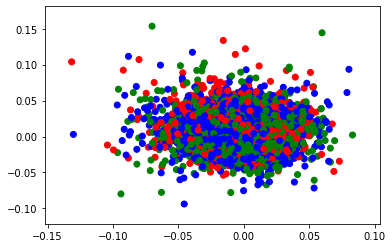

In [17]:
from cell import plot_utils

emb = pd.DataFrame(h.detach().numpy())
emb['class'] = data.labels
def color_df(df):

    if (df['class'] == 0):
        return 'Red'
    elif (df['class'] == 1):
        return 'green'
    elif (df['class'] == 2):
        return 'blue'

emb['cluster_color'] = emb.apply(color_df, axis = 1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(emb[0], emb[1], c = emb['cluster_color'])

plt.show()

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2 , random_state=42)
emb = tsne.fit_transform(h.detach().numpy())

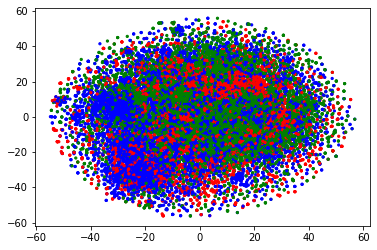

In [19]:
tsne_emb_20 = pd.DataFrame(emb)
tsne_emb_20['class'] = data.labels
def color_df(df):

    if (df['class'] == 0):
        return 'Red'
    elif (df['class'] == 1):
        return 'green'
    elif (df['class'] == 2):
        return 'blue'

tsne_emb_20['cluster_color'] = tsne_emb_20.apply(color_df, axis = 1)

plt.scatter(tsne_emb_20[0], tsne_emb_20[1], c=tsne_emb_20['cluster_color'], s=5)

# TSNE with 600 dim

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2 , random_state=42)
emb = tsne.fit_transform(h.detach().numpy())

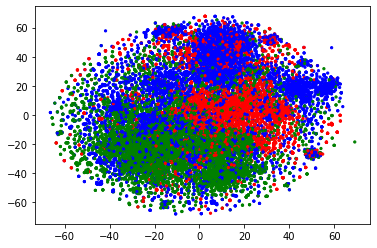

In [27]:
# tsne_emb = pd.DataFrame(emb)
# tsne_emb['class'] = data.labels
# def color_df(df):

#     if (df['class'] == 0):
#         return 'Red'
#     elif (df['class'] == 1):
#         return 'green'
#     elif (df['class'] == 2):
#         return 'blue'

# tsne_emb['cluster_color'] = tsne_emb.apply(color_df, axis = 1)

plt.scatter(tsne_emb[0], tsne_emb[1], c=tsne_emb['cluster_color'], s=5)